# Overview
This Notebook is used to reproduce all Figures in the paper "Validating Small-Molecule Force Fields for Macrocyclic Compounds Using NMR Data in Different Solvents"

# Naming conventions
* in the code, the force fields have simplified names: OpenFF 2 -> openff; GaFF 2 -> amber; OPLS/AA -> opls; XFF/DASH -> xff-dash
* The compounds are called by the first author of the paper, plus the compound name. You can find all names in the COMPOUNDS_PRETTY dict

## The Simulation class
This notebook uses the `Simulation` class to specify a simulation to be loaded.
The Simulation class knows about folder structure, filenames etc. In this Notebook, it is only used to find a csv file, but it also works
with many of the post-processing functions.

**Usage:** `Simulation("compound", "forcefield", "simulation_method", "solvent")`

### Available settings
* compound: `begnini-compound-1`, `begnini-compound-2`, `poongavanam-g16`, `poongavanam-e2-enant`, `danelius-rifampicin`, `danelius-roxithromycin`, `danelius-telithromycin`, `danelius-spiramycin`, `danelius-rifampicin-charged`, `danelius-roxithromycin-charged`, `danelius-telithromycin-charged`, `danelius-spiramycin-charged`, `peng-lorlatinib`, `comeau-nleu5r`, `comeau-nleu5s`
* forcefield: `openff` (OpenFF 2.0), `amber` (GaFF 2), `opls` (OPLS/AA), `xff-dash` (XFF with DASH charges)
* method: `hremd-quadratic` (REST2 with quadratic lambda placement), `hremd-exponential` (REST2 with exponential lambda placement, only for a few compounds)
* solvent: `chcl3`, `water` (only for a few compounds), `dmso` (only for a few compounds)

# Setup

In [1]:
from copy import deepcopy
from io import BytesIO, StringIO
import json
from tempfile import TemporaryDirectory
import threading
from time import sleep
from ast import literal_eval

import rdkit.Chem.AllChem
from rdkit import Chem

from PIL import Image
import IPython.display
import mdtraj as md
import numpy as np
import nglview as nv
import pandas as pd
import matplotlib.pyplot as plt
import scipy.spatial.transform

from file_structure import Simulation, molfile_path

Chem.rdDepictor.SetPreferCoordGen(True)

In [2]:
COMPOUNDS_PRETTY = {
    'begnini-compound-1': 'BC1',
    'begnini-compound-2': 'BC2',
    'poongavanam-g16': 'G16',
    'poongavanam-e2-enant': 'E2-enant',
    'danelius-rifampicin': 'Rifampicin',
    'danelius-roxithromycin': 'Roxithromycin',
    'danelius-telithromycin': 'Telithromycin',
    'danelius-spiramycin': 'Spiramycin',
    'danelius-rifampicin-charged': 'Rifampicin',
    'danelius-roxithromycin-charged': 'Roxithromycin',
    'danelius-telithromycin-charged': 'Telithromycin',
    'danelius-spiramycin-charged': 'Spiramycin',
    'peng-lorlatinib': 'Lorlatinib',
    'comeau-nleu5r': 'NLeu5R',
    'comeau-nleu5s': 'NLeu5S',
    'roche-1': 'RO1',
    'roche-2': 'RO2',
    'roche-3': 'RO3',
    'roche-4': 'RO4',
    'roche-5': 'RO5',
    'roche-6': 'RO6',
}

FORCEFIELDS_PRETTY = {
    "openff": "OpenFF 2",
    "amber": "GAFF2",
    "opls": "OPLS/AA",
    "xff-dash": "XFF/DASH",
}

In [3]:
def get_results_table(sim):
    df = pd.read_csv(
        f"outputs/match-to-noes/{sim.compound}_{sim.solvent}_{sim.method}_{sim.forcefield}.csv",
        index_col=0,
    ).set_index("restraint_number")
    df['violation'] = df['computed_distance'] - df['distance_ab']
    return df

get_results_table(Simulation("poongavanam-e2-enant", "openff", "hremd-quadratic", "water"))

,proton_a,proton_b,delta_a,delta_b,sigma,r2,distance_ab,index_a,index_b,top_distance,computed_distance,distance_split_0,distance_split_1,distance_split_2,distance_split_3,distance_split_4,violation
restraint_number,,,,,,,,,,,,,,,,,
1,7,8,2.07,1.33,0.000113,0.99,2.10,[38],"[40, 41]",3.0,2.464554,2.465896,2.463460,2.464224,2.463196,2.466002,0.364554
2,7,8,1.81,1.33,0.000039,0.98,2.51,[38],"[40, 41]",3.0,2.464554,2.465896,2.463460,2.464224,2.463196,2.466002,-0.045446
3,7,10,1.81,2.37,0.000048,0.99,2.42,[38],[44],5.0,4.340477,4.330137,4.344683,4.354949,4.332180,4.340762,1.920477
4,8,10,1.33,1.70,0.000044,0.99,2.45,"[40, 41]",[44],4.0,2.661219,2.651373,2.665980,2.666217,2.663288,2.659440,0.211219
5,10,20,1.70,2.94,0.000027,0.99,2.66,[44],"[48, 49, 47]",5.0,2.814171,2.823758,2.814873,2.800987,2.816267,2.815309,0.154171
6,24,23,7.61,2.87,0.000006,0.86,3.43,[65],"[57, 58, 59]",6.0,3.562651,3.642557,3.571569,3.531102,3.548683,3.527761,0.132651
7,6,7,3.62,2.07,0.000059,0.97,2.34,[37],[38],3.0,2.528902,2.532347,2.526073,2.529156,2.524478,2.532529,0.188902
8,7,19,2.07,3.32,0.000024,0.95,2.72,[38],"[34, 35, 36]",5.0,2.750602,2.754371,2.745734,2.753214,2.741422,2.758516,0.030602
9,8,19,2.02,3.32,0.000007,0.95,3.33,"[40, 41]","[34, 35, 36]",6.0,4.020962,4.019148,4.015302,4.039573,3.996984,4.034807,0.690962


## Aggregation functions

In [4]:
def root_mean_square(arr):
    " sqrt(mean(x**2)) "
    return np.sqrt(np.mean(arr**2))

def mean_positive(arr):
    " mean(max(x, 0)) "
    return np.mean(np.maximum(arr, 0))

def mean_absolute(arr):
    " mean(abs(x)) "
    return np.mean(np.abs(arr))

def fraction_above(arr, cutoff=1):
    " fraction of values above a cutoff "
    return np.mean(arr > cutoff)

## Helper functions

In [5]:
def sort_by_nth_lowest(df, n):
    nth_lowest = np.sort(df.values, axis=1)[:, n]
    return df.iloc[np.argsort(nth_lowest)]

def standard_md_method(compound):
    return "hremd-with-angles" if compound == "peng-lorlatinib" else "hremd-quadratic"

In [6]:
# These functions are for visualization of MDTraj objects using NGLView

class MDTrajTrajectory2(nv.MDTrajTrajectory):
    def __init__(self, trajectory, rdk_mol=None):
        self.rdk_mol = rdk_mol
        super().__init__(trajectory)

    def get_structure_string(self):
        if self.rdk_mol is None:
            super().get_structure_string()
        return Chem.MolToPDBBlock(self.rdk_mol)

def show_mdtraj2(mdtraj_trajectory, rdk_mol=None, **kwargs):
    '''Show mdtraj trajectory with optional Rdkit mol for bond info.

    Examples
    --------
    >>> import nglview as nv # doctest: +SKIP
    ... import mdtraj as md
    ... t = md.load(nv.datafiles.XTC, top=nv.datafiles.GRO)
    ... w = nv.show_mdtraj2(t)
    ... w
    '''
    structure_trajectory = MDTrajTrajectory2(mdtraj_trajectory, rdk_mol=rdk_mol)
    return nv.NGLWidget(structure_trajectory, **kwargs)


def add_bounds_to_view(view, traj, atoms1, atoms2):
    new_traj = get_dummy_mdtraj_2_atoms()
    new_traj.xyz = np.zeros((traj.n_frames, new_traj.n_atoms, 3))
    new_traj.xyz[:, 0, :] = traj.xyz[:, atoms1, :].mean(1)
    new_traj.xyz[:, 1, :] = traj.xyz[:, atoms2, :].mean(1)
    view.add_trajectory(new_traj)


def get_render_results(view, results):
    """Collect the results of rendering frames in NGLview
    
    Note: Rendering has to be done in a separate thread to unblock the main thread.
    
    Parameters
    ----------
    view: NGLWidget
    results: list
        To store the output (each element will be a bytes object with the png image)
    """
    for i_frame in range(N_CLUSTERS):
        img = view.render_image(frame=i_frame, transparent=True)
        maxsteps = 50
        for _ in range(maxsteps):
            if img.value:
                break
            sleep(0.1)
        results.append(deepcopy(img.value))


def get_dummy_mdtraj_2_atoms():
    """This will serve as a template to add 2-atom representations (for distance bounds) to an NGLview widget"""
    with TemporaryDirectory() as tmp:
        fname = f"{tmp}/temp.pdb"
        with open(fname, "w") as f:
            print(
"""ATOM      1  Cl1 MOL     1      00.000  00.000  00.000  1.00  0.00           Cl 
ATOM      2  Cl2 MOL     1      00.000  00.000  00.000  1.00  0.00           Cl 
CONECT    1    2
""", file=f)
        traj = md.load_pdb(fname)
    return traj

def get_ring_orientation(mol: Chem.Mol, xyz=None, atoms_offset=0, invert_ring=False):
    """Return the *current* rotation matrix corresponding to the longest ring in mol.
    
    Rotation is such that the first atom points roughly in -x direction, and the atoms at 1/4 of the ring point roughly in y direction.
    """
    assert atoms_offset >= 0
    ring = list(max(Chem.GetSSSR(mol), key=len))
    ring = ring[atoms_offset:] + ring[:atoms_offset]
    if invert_ring:
        ring = ring[::-1]
    if xyz is None:
        crd = np.array(mol.GetConformer().GetPositions())
    else:
        crd = xyz
    ring_crd = crd[ring]
    # center of geometry
    center = np.mean(ring_crd, axis=0)
    ring_crd -= center
    t = np.linspace(0, 2*np.pi, len(ring), endpoint=False)[:, np.newaxis]
    x = (-np.cos(t) * ring_crd).sum(0)
    x = x / np.sqrt(np.sum(x**2))
    y = (np.sin(t) * ring_crd).sum(0)
    # force y to be normal to x
    proj = (x*y).sum() * x
    y -= proj
    y = y / np.sqrt(np.sum(y**2))
    z = np.cross(x, y)
    z = z / np.sqrt(np.sum(z**2))
    # x, y, z are columns of the rotation matrix
    rotmat = np.stack([x, y, z], axis=-1)
    return rotmat, center

def transform_into_standard_orientation(xyz, ref_mol, atoms_offset, invert_ring=False):
    rotmat, center = get_ring_orientation(ref_mol, xyz=xyz, atoms_offset=atoms_offset, invert_ring=invert_ring)
    xyz = np.asarray(xyz) - center
    xyz = np.matmul(np.linalg.inv(rotmat), xyz.T).T
    return xyz

In [7]:
mol = Chem.MolFromMolFile("../data/danelius-roxithromycin-charged/reference-atom-order.mol")
#assert get_ring_orientation(mol, 0) == [1, 54, 41, 40, 27, 24, 23, 21, 12, 11, 9, 6, 3, 2]
rotmat, center = get_ring_orientation(mol, atoms_offset=3)
(rotmat[:, 0] * rotmat[:, 1]).sum()

-6.938893903907228e-18

# Figure 1: Compounds

In [8]:
def show_images(imgs, buffer=5, n_per_row=4):
    height = max(img.height for img in imgs)
    width = max(img.width for img in imgs)
    total_width = width*n_per_row + buffer * (n_per_row-1)
    n_rows = (len(imgs)-1) // n_per_row + 1
    total_height = height*n_rows + buffer * (n_rows-1)
    res = Image.new("RGBA", (total_width, total_height))
    for i, img in enumerate(imgs):
        ix = i % n_per_row
        iy = i // n_per_row
        res.paste(img, (ix*(width+buffer), iy*(height+buffer)))
    return res

def show_mol(mol, legend=''):
    sssr = [list(ring) for ring in Chem.GetSSSR(mol)]
    longest_ring = max(sssr, key=len)

    width, height = 350, 300
    d2d = Chem.Draw.MolDraw2DCairo(width, height)
    d2d.SetFontSize(18)
    dopts = d2d.drawOptions()
    dopts.setHighlightColour((0.6, 1, 1, 1))
    d2d.DrawMolecule(mol, legend=legend, highlightAtoms=longest_ring)
    d2d.FinishDrawing()
    bio = BytesIO(d2d.GetDrawingText())
    return Image.open(bio)

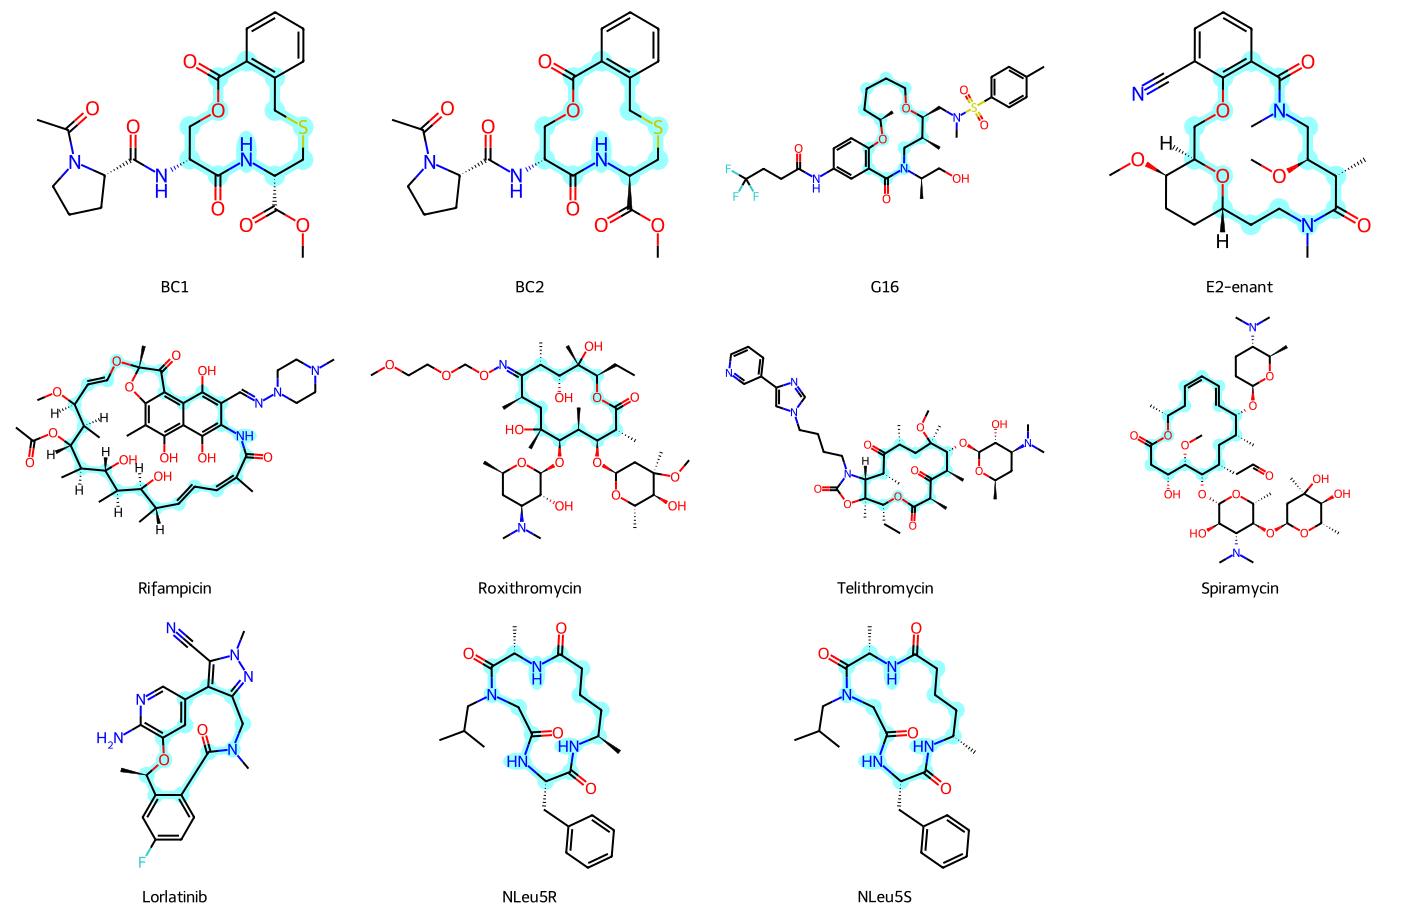

In [9]:
compounds = [c for c in COMPOUNDS_PRETTY if not c.startswith("roche")]
mols = {
    c: Chem.Mol(Chem.MolFromMolFile(molfile_path(c)), quickCopy=True)
    for c in compounds
}

imgs = []
for name, mol in mols.items():
    if "charged" not in name:
        imgs.append(show_mol(mol, legend=COMPOUNDS_PRETTY[name]))

img = show_images(imgs, n_per_row=4)
with open("outputs/figure-mols.png", "wb") as f:
    img.save(f, format="png")
img

# Plot for a single simulation

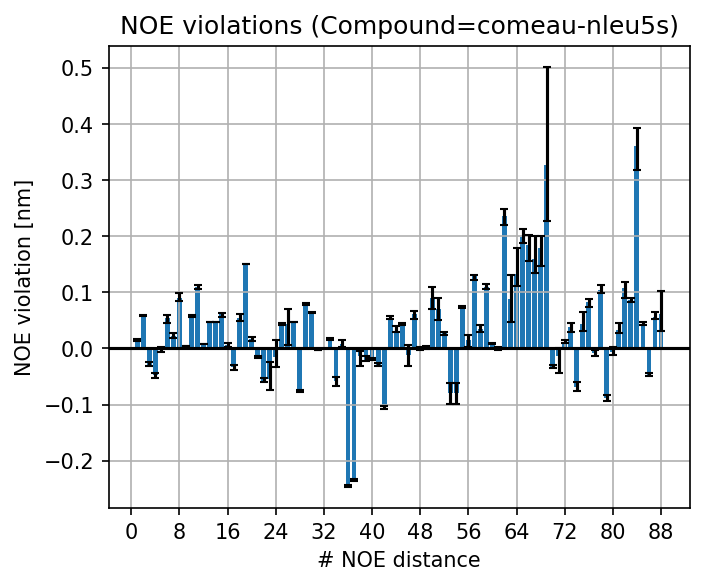

In [10]:
ANGSTROM_PER_NM = 10.

def norm_and_cmap_for_topological_distance(cmap='viridis'):
    cmap = plt.get_cmap(cmap, 9)
    norm = plt.cm.colors.Normalize(2 - 0.5, 10 + 0.5)
    return norm, cmap

def colorcode_topological_distances(distances):
    norm, cmap = norm_and_cmap_for_topological_distance()
    colors = cmap(norm(distances))
    return colors

def create_colorbar_for_topological_distance(figure=None, **kwargs):
    figure = figure or plt.gcf()
    norm, cmap = norm_and_cmap_for_topological_distance()
    c_title = "Topological distance"
    cbar = figure.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), **kwargs)
    cbar.set_label(c_title)
    return cbar

def make_plot(simulation, ax=None, title=None):
    ax = ax or plt.gca()
    plot_df = get_results_table(simulation)
    # Remove NOE distances between hydrogens on the same carbon
    #colors = colorcode_topological_distances(plot_df['top_distance'].values)
    #cbar = create_colorbar_for_topological_distance(ax=ax)
    # Plot
    ax.bar(plot_df.index, plot_df['violation'] / ANGSTROM_PER_NM, label='full') # , color=colors
    N_CHUNKS = 5
    # Plot chunks as individual points
    #for i in range(N_CHUNKS):
    #    violation = (plot_df[f'distance_split_{i}'] - plot_df['distance_ab']) / ANGSTROM_PER_NM
    #    ax.scatter(violation.index, violation, label=f"split {i+1}", s=10)
    # Plot chunks as min-max bars
    chunk_violations = [
        (plot_df[f'distance_split_{i}'] - plot_df['distance_ab']) / ANGSTROM_PER_NM
        for i in range(N_CHUNKS)
    ]
    chunk_min = -(np.min(chunk_violations, axis=0) - plot_df['violation'] / ANGSTROM_PER_NM)
    chunk_max = np.max(chunk_violations, axis=0) - plot_df['violation'] / ANGSTROM_PER_NM
    plt.errorbar(plot_df.index, plot_df['violation'] / ANGSTROM_PER_NM, [chunk_min, chunk_max], linestyle="", color='k', capsize=2)
    #ax.legend()
    ax.axhline(0, color='k')
    title = f'NOE violations (Compound={simulation.compound})' if title is None else title
    ax.set(xlabel='# NOE distance', ylabel='NOE violation [nm]', title=title)
    tick_spacing = max(2, int(np.ceil(len(plot_df) / 12)))
    ax.xaxis.set_major_locator(plt.MultipleLocator(tick_spacing))

plt.figure(dpi=150, figsize=(5, 4))
sim = Simulation('comeau-nleu5s', 'openff', 'hremd-quadratic', 'chcl3', state=0)
make_plot(sim)
plt.grid()
#plt.savefig("outputs/my-favorite-violation-plot.png", dpi=300)
plt.show()

## Figure 2: BC1, NLeu5S

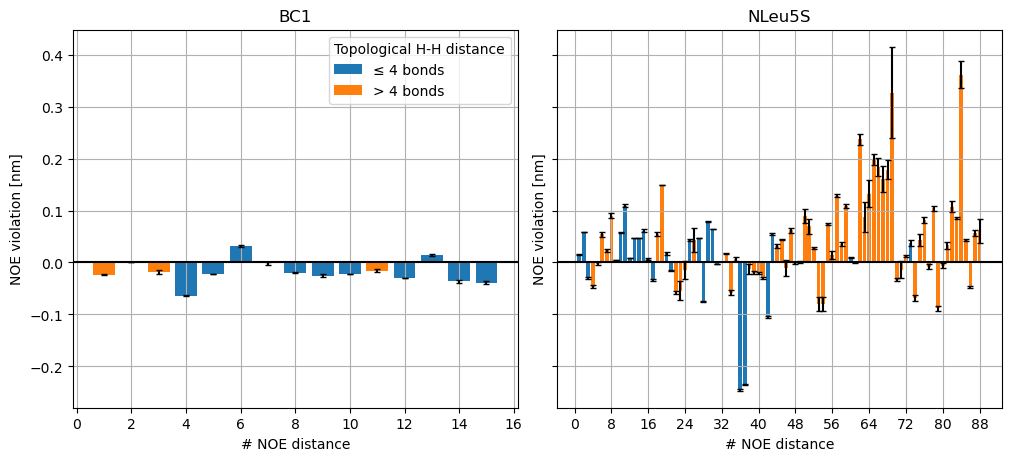

In [11]:
def make_plot(simulation, frame_selection=None, ax=None, use_ring_distance=False, restraints_df=None):
    ax = ax or plt.gca()
    plot_df = get_results_table(simulation)
    # Plot
    ax.bar(plot_df.query('top_distance <= 4.0').index, plot_df.query('top_distance <= 4.0')['violation'] / ANGSTROM_PER_NM, label='≤ 4 bonds')
    ax.bar(plot_df.query('top_distance > 4.0').index, plot_df.query('top_distance > 4.0')['violation'] / ANGSTROM_PER_NM, label='> 4 bonds')
    N_CHUNKS = 5
    std = np.array([
        (plot_df[f'distance_split_{i}'] - plot_df['distance_ab']).values
        for i in range(N_CHUNKS)
    ]).std(0)
    ax.errorbar(plot_df.index, plot_df['violation'] / ANGSTROM_PER_NM, std / ANGSTROM_PER_NM, fmt='k.', markersize=0, capsize=2)
    #ax.legend()
    ax.axhline(0, color='k')
    ax.set(xlabel='# NOE distance', ylabel='NOE violation [nm]')
    tick_spacing = max(2, int(np.ceil(len(plot_df) / 12)))
    ax.xaxis.set_major_locator(plt.MultipleLocator(tick_spacing))

fig, axes = plt.subplots(1, 2, figsize=(10, 4.5), sharey=True, layout='constrained')

sims = {
    #"Lorlatinib": Simulation("peng-lorlatinib", "openff", "hremd-with-angles", "chcl3"),
    "BC1": Simulation("begnini-compound-1", "openff", "hremd-quadratic", "chcl3"),
    "NLeu5S": Simulation("comeau-nleu5s", "openff", "hremd-quadratic", "chcl3"),
}

for ax, (title, sim) in zip(axes, sims.items()):
    make_plot(sim, ax=ax)
    ax.set_title(title)
    ax.grid()
axes[0].legend(title="Topological H-H distance", alignment="left")
plt.savefig("outputs/figure-2-bc1-nleu5s-example.png", dpi=300)
plt.show()

## Cis/trans isomers
* Since there are substantial violations for the NLeu5S compound, we tested whether there might be a substantial fraction of cis amide bonds, and whether this might affect the results.
* This is the same plot as above (Figure 2), but comparing the full simulation with a filtered version using only using frames where all amino acids are in trans configuration.
* The results are basically the same, indicating that cis-trans isomerization is not a major issue for the resulting plots.

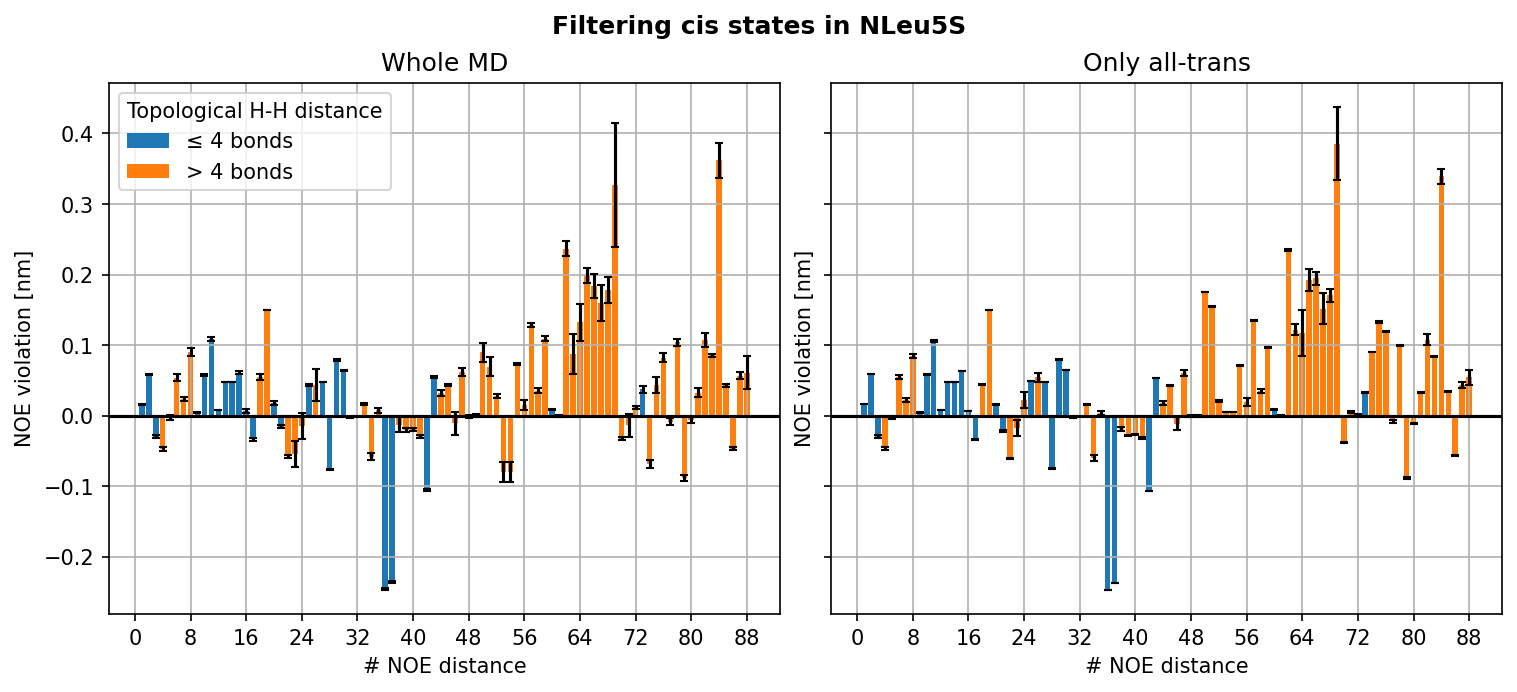

In [12]:
def make_plot(simulation, frame_selection=None, ax=None, use_ring_distance=False, restraints_df=None):
    ax = ax or plt.gca()
    plot_df = get_results_table(simulation)
    # Plot
    ax.bar(plot_df.query('top_distance <= 4.0').index, plot_df.query('top_distance <= 4.0')['violation'] / ANGSTROM_PER_NM, label='≤ 4 bonds')
    ax.bar(plot_df.query('top_distance > 4.0').index, plot_df.query('top_distance > 4.0')['violation'] / ANGSTROM_PER_NM, label='> 4 bonds')
    N_CHUNKS = 5
    std = np.array([
        (plot_df[f'distance_split_{i}'] - plot_df['distance_ab']).values
        for i in range(N_CHUNKS)
    ]).std(0)
    ax.errorbar(plot_df.index, plot_df['violation'] / ANGSTROM_PER_NM, std / ANGSTROM_PER_NM, fmt='k.', markersize=0, capsize=2)
    #ax.legend()
    ax.axhline(0, color='k')
    ax.set(xlabel='# NOE distance', ylabel='NOE violation [nm]')
    tick_spacing = max(2, int(np.ceil(len(plot_df) / 12)))
    ax.xaxis.set_major_locator(plt.MultipleLocator(tick_spacing))

fig, axes = plt.subplots(1, 2, figsize=(10, 4.5), sharey=True, layout='constrained', dpi=150)

sims = {
    #"Lorlatinib": Simulation("peng-lorlatinib", "openff", "hremd-with-angles", "chcl3"),
    "Whole MD": Simulation("comeau-nleu5s", "openff", "hremd-quadratic", "chcl3"),
    "Only all-trans": Simulation("comeau-nleu5s", "openff_all-trans", "hremd-quadratic", "chcl3"),
}

for ax, (title, sim) in zip(axes, sims.items()):
    make_plot(sim, ax=ax)
    ax.set_title(title)
    ax.grid()
axes[0].legend(title="Topological H-H distance", alignment="left")
fig.suptitle("Filtering cis states in NLeu5S", fontweight="bold")
#plt.savefig("/localhome/fwaibl/macrocycle-ff-benchmark/paper-figures/nleu5s-trans-filtering.png", dpi=300)
plt.show()

# Aggregated plots

## Figure 4: Chloroform, Water & DMSO

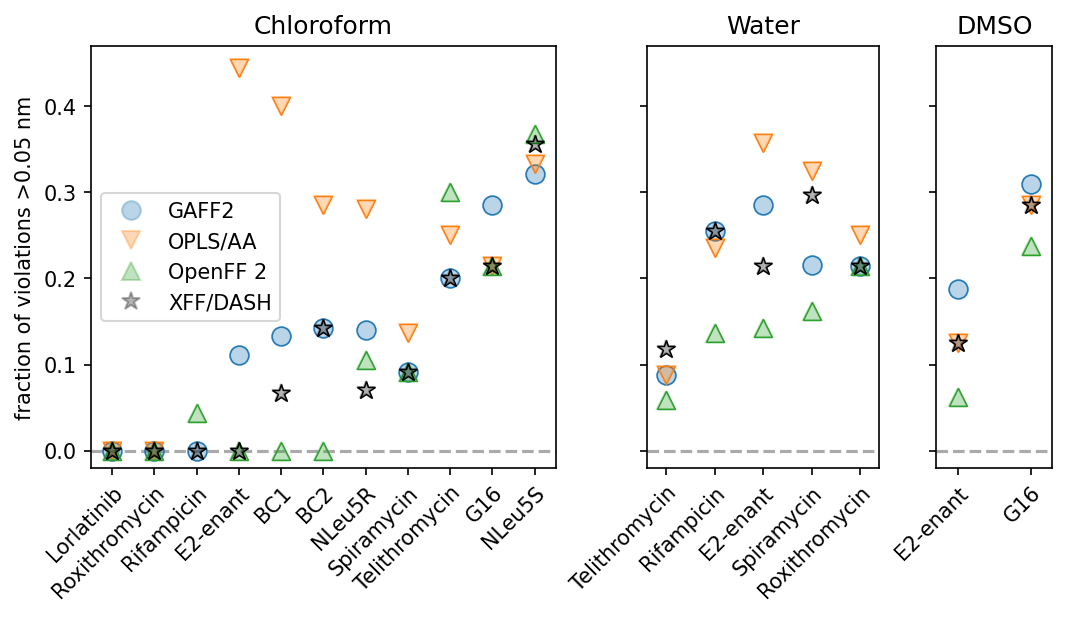

In [14]:
# Setup
fig, axes = plt.subplots(1, 3, figsize=(7, 4), dpi=150, layout='constrained', sharey=True, gridspec_kw={'width_ratios': [4, 2, 1]})
aggregation = lambda x: fraction_above(x, cutoff=.5)
axes[0].axhline(0, color='#aaa', linestyle='--')
axes[1].axhline(0, color='#aaa', linestyle='--')
axes[2].axhline(0, color='#aaa', linestyle='--')

axes[0].set_ylim(-0.02, 0.47)

colors = [row['color'] for row in plt.rcParams['axes.prop_cycle']][:4]
colors[3] = '#000'

forcefields = list(FORCEFIELDS_PRETTY.keys())

# Chloroform
compounds = [
    'begnini-compound-1', 'begnini-compound-2',
    'poongavanam-g16', 'poongavanam-e2-enant',
    'danelius-rifampicin', 'danelius-roxithromycin', 'danelius-telithromycin', 'danelius-spiramycin',
    'peng-lorlatinib',
    'comeau-nleu5r', 'comeau-nleu5s',
]

aggregation = lambda x: fraction_above(x, cutoff=.5)
plot_df = pd.Series({
    (COMPOUNDS_PRETTY[compound], FORCEFIELDS_PRETTY[ff]): get_results_table(
        Simulation(compound, ff, standard_md_method(compound), 'chcl3'),
    )['violation']
    for compound in compounds
    for ff in forcefields
    if (compound, ff) != ('danelius-rifampicin', 'opls')
})
plot_df_agg = plot_df.map(aggregation).unstack(level=1)
# sort by the lowest value
for n in range(3, -1, -1):
    plot_df_agg = sort_by_nth_lowest(plot_df_agg, n)
for col, marker, color in zip (plot_df_agg, "ov^*", colors):
    axes[0].plot(plot_df_agg.index, plot_df_agg[col], label=col, markersize=9, marker=marker, linestyle='none', color=color, alpha=0.3)
    axes[0].plot(plot_df_agg.index, plot_df_agg[col], markersize=9, marker=marker, linestyle='none', color=color, markeredgewidth=0.7, markerfacecolor='None')
plt.xticks(rotation=45, ha='right', rotation_mode="anchor")
plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
axes[0].set(ylabel="fraction of violations >0.05 nm")
axes[0].set_ylim(-0.02, 0.47)
axes[0].set_title("Chloroform")

# Water
compounds = [
    'poongavanam-e2-enant',
    'danelius-rifampicin-charged', 'danelius-roxithromycin-charged', 'danelius-telithromycin-charged', 'danelius-spiramycin-charged',
]

def standard_md_method(compound):
    return "hremd-with-angles" if compound == "peng-lorlatinib" else "hremd-quadratic"

plot_df = pd.Series({
    (COMPOUNDS_PRETTY[compound], FORCEFIELDS_PRETTY[ff]): get_results_table(
        Simulation(compound, ff, standard_md_method(compound), 'water'),
    )['violation']
    for compound in compounds
    for ff in forcefields
    if (compound, ff) != ('danelius-rifampicin', 'opls')
})
plot_df_agg = plot_df.map(aggregation).unstack(level=1)
# sort by the lowest value
for n in range(3, -1, -1):
    plot_df_agg = sort_by_nth_lowest(plot_df_agg, n)
for col, marker, color in zip (plot_df_agg, "ov^*", colors):
    axes[1].plot(plot_df_agg.index, plot_df_agg[col], label=col, markersize=9, marker=marker, linestyle='none', color=color, alpha=0.3)
    axes[1].plot(plot_df_agg.index, plot_df_agg[col], markersize=9, marker=marker, linestyle='none', color=color, markeredgewidth=0.7, markerfacecolor='None')
plt.setp(axes[1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
axes[1].set_title("Water")
axes[1].margins(x=0.1)

# DMSO
compounds = ['poongavanam-e2-enant', 'poongavanam-g16']
plot_df = pd.Series({
    (COMPOUNDS_PRETTY[compound], FORCEFIELDS_PRETTY[ff]): get_results_table(
        Simulation(compound, ff, standard_md_method(compound), 'dmso'),
    )['violation']
    for compound in compounds
    for ff in forcefields
    if (compound, ff) != ('danelius-rifampicin', 'opls')
})
plot_df_agg = plot_df.map(aggregation).unstack(level=1)
# sort by the lowest value
for n in range(3, -1, -1):
    plot_df_agg = sort_by_nth_lowest(plot_df_agg, n)
for col, marker, color in zip (plot_df_agg, "ov^*", colors):
    axes[2].plot(plot_df_agg.index, plot_df_agg[col], label=col, markersize=9, marker=marker, linestyle='none', color=color, alpha=0.3)
    axes[2].plot(plot_df_agg.index, plot_df_agg[col], markersize=9, marker=marker, linestyle='none', color=color, markeredgewidth=0.7, markerfacecolor='None')
plt.setp(axes[2].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
axes[2].set_title("DMSO")
axes[2].margins(x=0.3)

axes[0].legend()
plt.savefig("outputs/figure-4-frac-violations-over-0.5.png", dpi=300)
plt.show()

## Figure 6: Roche compounds figure
**It will not be possible to run this without the (unpublished) simulations of the Roche compounds**

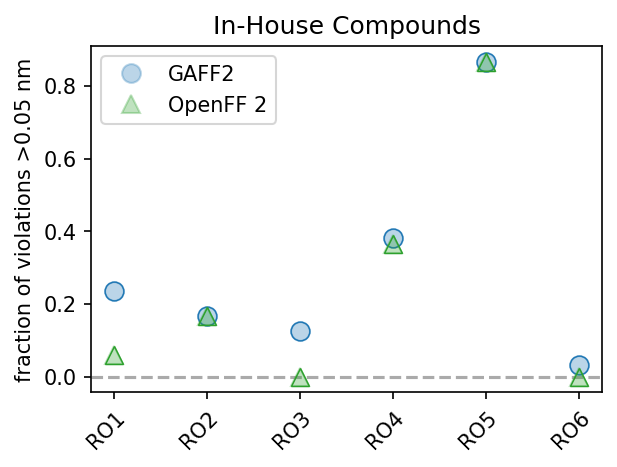

In [15]:
compounds_and_solvents = [("water", ['roche-1', 'roche-2', 'roche-3']), ("dmso", ['roche-4', 'roche-5', 'roche-6'])]
forcefields = ["openff", "amber"]

def standard_md_method(compound):
    return "hremd-with-angles" if compound == "peng-lorlatinib" else "hremd-quadratic"

fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150, layout='constrained')
aggregation = lambda x: fraction_above(x, cutoff=.5)
plot_df = pd.Series({
    (COMPOUNDS_PRETTY[compound], FORCEFIELDS_PRETTY[ff]): get_results_table(
        Simulation(compound, ff, standard_md_method(compound), solvent),
    )['violation']
    for solvent, compounds in compounds_and_solvents
    for compound in compounds
    for ff in forcefields
})

ax.axhline(0, color='#aaa', linestyle='--')

colors = [row['color'] for row in plt.rcParams['axes.prop_cycle']][:4]
colors[3] = '#000'
# select colors to be consistent with the colors for GAFF2 and OpenFF 2 in Figure 4
colors = [colors[0], colors[2]]

plot_df_agg = plot_df.map(aggregation).unstack(level=1)
#for n in range(1, -1, -1):
#    plot_df_agg = sort_by_nth_lowest(plot_df_agg, n)

# also use the appropriate markers to be consistent with Figure 4
for col, marker, color in zip (plot_df_agg, "o^", colors):
    ax.plot(plot_df_agg.index, plot_df_agg[col], label=col, markersize=9, marker=marker, linestyle='none', color=color, alpha=0.3)
    ax.plot(plot_df_agg.index, plot_df_agg[col], markersize=9, marker=marker, linestyle='none', color=color, markeredgewidth=0.7, markerfacecolor='None')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_title("In-House Compounds")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set(ylabel="fraction of violations >0.05 nm")
ax.legend()
plt.savefig("outputs-figure-6-frac-violations-over-0.5-roche.png", dpi=300)
plt.show()

# Figure 3: NLeu5S clusters
## Important notes
* This figure requires that `nleu5s-clustering.sh` has been run, and its output files are there.

**Workflow:**
* Adapt the `ATOMS_OFFSET` to rotate along the ring. And possibly use `INVERT_RING` to flip the whole molecule by 180 degrees (the molecule is set into a standard orientation based on the ring. `INVERT_RING` reverts the order of the atoms when creating the reference orientation.)
* Zoom in and/or move the molecule to fit the figure as tightly as possible, but don't rotate.
* Move the frames slider at least once to make sure that all parts of the view are at the same frame.
* Run the cell that renders the 5 frames. Then *wait* until it is done.
* *After the rendering is done*, run the cell that saves the png files.
* Run the cell that displays the final figure as HTML.
* Then, screenshot the figure. If you want the exact size, you can take a screenshot from the developer console.

## Function definitions

In [122]:
cm = nv.color.ColormakerRegistry

cm.add_scheme_func(
    "ring_color",
    """
    this.atomColor = function(atom) {
        if (atom.element == "H") {return "0xFFFFFF";}
        if (atom.element == "C") {return "0x606060";}
        if (atom.element == "N") {return "0x3050F8";}
        if (atom.element == "O") {return "0xFF0D0D";}
        if (atom.element == "F") {return "0x90E050";}
    };
    """
)
cm.add_scheme_func(
    "out_of_ring_color",
    """
    this.atomColor = function(atom) {
        if (atom.element == "H") {return "0xFFFFFF";}
        if (atom.element == "C") {return "0xaaaaaa";}
        if (atom.element == "N") {return "0x3050F8";}
        if (atom.element == "O") {return "0xFF0D0D";}
        if (atom.element == "F") {return "0x90E050";}
    };
    """
)

def rgb2hex(r, g, b, _a=None):
    print(any([isinstance(x, float) for x in (r, g, b)]))
    if any([isinstance(x, float) for x in (r, g, b)]):
        r = min(int(r*256), 255)
        g = min(int(g*256), 255)
        b = min(int(b*256), 255)
    print(r, g,b )
    return "#{:02x}{:02x}{:02x}".format(r,g,b)

## Load cluster populations and violations

In [123]:
cluster_pops = pd.read_csv("outputs/clustering/comeau-nleu5s-cluster-summary.dat", delim_whitespace=True, index_col="#Cluster")["Frac"]
cluster_pops

#Cluster
0    0.973
1    0.020
2    0.004
3    0.003
4    0.000
Name: Frac, dtype: float64

In [124]:
idx_viol = get_results_table(Simulation("comeau-nleu5s", "openff", "hremd-quadratic", "chcl3"))[["violation", "index_a", "index_b"]].sort_values("violation", ascending=False)
idx_viol.head()

,violation,index_a,index_b
restraint_number,,,
84,3.617218,"[40, 41, 42]","[50, 53]"
69,3.269298,"[64, 62, 63]","[50, 53]"
62,2.367821,[44],"[50, 53]"
65,1.985465,"[65, 66, 67]",[45]
66,1.840917,"[65, 66, 67]",[46]


## Render NGLview
**Note: the initial rendering looks wrong (bounds and structure are from different frames). Move the frame slider back and forth to get a correct rendering**

In [127]:
BOUND_COLOR = "#cccc00"  # dark yellow
# BOND_1_BEGIN_H = "50,53"
# BOND_1_END_H = "62,63,64"
# BOND_2_BEGIN_H = "50,53"
# BOND_2_END_H = "40,41,42"
N_CLUSTERS = 5
bounds = idx_viol.sort_values("violation", ascending=False).head(5)#.query("violation > 0.5")
BOUND_COLOR = "#cccc00"  # dark yellow
bound_cmap = plt.get_cmap("inferno_r")

mol = Chem.MolFromMolFile("../data/comeau-nleu5s/reference-atom-order.mol", removeHs=False)
ring = list(max(Chem.GetSSSR(mol), key=len))

visible_hs = set()
for _, row in bounds.iterrows():
    visible_hs.update(literal_eval(row["index_a"]))
    visible_hs.update(literal_eval(row["index_b"]))

traj = md.join([
    md.load(f"./outputs/nleu5s-clusters/cluster.c{i}.pdb")
    #md.load(f"./outputs/clustering/comeau-nleu5s-cluster.c{i}.pdb")
    for i in range(0, N_CLUSTERS)
])

visible_hs.update([at.GetIdx() for at in mol.GetAtoms() if at.GetSymbol() == "H" and at.GetNeighbors()[0].GetSymbol() in ["N", "O"]])
H_SEL = ",".join([str(i) for i in visible_hs])
RING_SEL = ",".join([str(i) for i in ring])

rep = [
    # ring
    # sticks only - we want to set stick width independent of the ball
    {"type": "ball+stick", "params": {
        "multipleBond": "symmetric",
        "radiusScale": 1.2,
        "cylinderOnly": True,
        "sele": f"@{RING_SEL}",
        "color": "ring_color",
    }},
    # everything else
    {"type": "ball+stick", "params": {
        "multipleBond": "symmetric",
        "radiusScale": 0.8,
        "color": "out_of_ring_color",
        "sele": f"not _H or @{H_SEL}",  # polar hydrogens and those used in the bounds
    }},
    # ring
    # ball+stick
    {"type": "ball+stick", "params": {
        "multipleBond": "symmetric",
        "radiusScale": 0.8,
        "color": "ring_color",
        "sele": f"@{RING_SEL}",
    }},
]

traj.center_coordinates()
traj = traj.superpose(traj, 0)
view = show_mdtraj2(traj, mol)
view.clear_representations()
view.representations = rep

i_view = 1
for _, row in bounds.iterrows():
    #color = rgb2hex(*bound_cmap(np.clip((row['violation'] - 0.5) / 0.5, 0, 1)))
    add_bounds_to_view(view, traj, literal_eval(row["index_a"]), literal_eval(row["index_b"]))
    view[i_view].clear()
    view[i_view].add_spacefill(colorValue=BOUND_COLOR, radiusScale=0.12)
    view[i_view].add_ball_and_stick(radiusScale=.6, colorValue=BOUND_COLOR, cylinderOnly=True)
    i_view += 1

view.display(gui=True)

NGLWidget(gui_style='ngl', max_frame=4)

In [ ]:
results = []
thread = threading.Thread(target=get_render_results, args=(view, results))
thread.start()

## Save images

In [ ]:
for i, img in enumerate(results):
    with open(f"outputs/nleu5s-clusters/cluster.c{i}.png", "wb") as f:
        f.write(img)

## Display final figure

In [128]:
# using suffix 1 to distinguish styles from those in the other HTML cell below
cluster_title_html = "\n".join([
    f'<td class="mytable1">Cluster {i} ({cluster_pops[i]*100:.1f}%)</td>'
    for i in range(N_CLUSTERS)
])
#cluster_pop_html = "\n".join([f'<td class="mytable1">{cluster_pops[i]*100:.1f}%</td>' for i in range(N_CLUSTERS)])
cluster_img_html = "\n".join([f'<td class="mytable1"><img class="myimage1" src="outputs/nleu5s-clusters/cluster.c{i}.png"></td>' for i in range(N_CLUSTERS)])
html_fig = """
<style>
    td.mytable1 {text-align: center !important; color: #000; background-color: #fff !important; font-size: 14pt; font-weight: bold; padding: 0pt}
    img.myimage1 {max-height: 100%;}
</style>
<table style="width: 1150pt; max-height: 200pt;">
<tr>""" + cluster_title_html + """</tr>
<tr>""" + cluster_img_html + """</tr>
</table>
"""
IPython.display.display(IPython.display.HTML(html_fig))

Cluster 0 (97.3%),Cluster 1 (2.0%),Cluster 2 (0.4%),Cluster 3 (0.3%),Cluster 4 (0.0%)
,,,,


# Figure 5: Roxithromycin and Telithromycin
**workflow:**
* run this with all combinations of roxithromycin/telithromycin and `water`/`chcl3`. Note that the names are e.g., `danelius-roxithromycin` in chlroform, and `danelius-roxithromycin-charged` in water.
* For each combination:
  * Adapt the `ATOMS_OFFSET` to rotate along the ring. And possibly use `INVERT_RING` to flip the whole molecule by 180 degrees (the molecule is set into a standard orientation based on the ring. `INVERT_RING` reverts the order of the atoms when creating the reference orientation.)
  * Zoom in and/or move the molecule to fit the figure as tightly as possible, but don't rotate.
  * Move the frames slider at least once to make sure that all parts of the view are at the same frame.
  * Run the cell that renders the 5 frames. Then *wait* until it is done.
  * *After the rendering is done*, run the cell that saves the png files.
* Run the cell that displays the final figure as HTML.
* Then, screenshot the figure. If you want the exact size, you can take a screenshot from the developer console.

In [20]:
CMP = "danelius-roxithromycin"
SOLVENT = "chcl3"
ATOMS_OFFSET = 11  # rotates the orientation of the ring in the visualizations
INVERT_RING = True
# 11/True for roxithromycin/chcl3 or roxithromycin/water
# 13/False for telithromycin/water or telithromycin/chcl3

In [21]:
# get the strongest violations
idx_viol = get_results_table(Simulation(CMP, "openff", "hremd-quadratic", SOLVENT))[["violation", "index_a", "index_b"]].sort_values("violation", ascending=False)
idx_viol.head()

,violation,index_a,index_b
restraint_number,,,
19,0.374236,[111],"[121, 122, 123]"
11,0.300797,[70],"[65, 66, 67]"
10,0.288690,[70],"[81, 82, 83]"
18,0.280103,[91],[98]
8,0.277089,[80],"[88, 89, 87]"


In [22]:
rmat = scipy.spatial.transform.Rotation.from_rotvec([90, 0, 0], degrees=True)
tilt = scipy.spatial.transform.Rotation.from_rotvec([-30, 0, 0], degrees=True)
rmat = rmat * tilt

In [23]:
def center_bounding_box(traj):
    for i_frame in range(traj.n_frames):
        crd = traj.xyz[i_frame]
        cmin = crd.min(axis=0)
        cmax = crd.max(axis=0)
        shift = (cmin + cmax) / 2
        traj.xyz[i_frame] = crd - shift

In [24]:
N_CLUSTERS = 5
#bounds = idx_viol.iloc[:2]
bounds = idx_viol.sort_values("violation", ascending=False).query("violation > 0.5")
BOUND_COLOR = "#cccc00"  # dark yellow
bound_cmap = plt.get_cmap("inferno_r")


visible_hs = set()
for _, row in bounds.iterrows():
    visible_hs.update(literal_eval(row["index_a"]))
    visible_hs.update(literal_eval(row["index_b"]))

mol = Chem.MolFromMolFile(f"../data/{CMP}/reference-atom-order.mol", removeHs=False)
ring = list(max(Chem.GetSSSR(mol), key=len))
print(f"{ring=}")
traj = md.join([
    md.load(f"./outputs/clustering/{CMP}-{SOLVENT}-cluster.c{i}.pdb")
    for i in range(0, N_CLUSTERS)
])
traj.xyz[0] = rmat.apply(transform_into_standard_orientation(traj.xyz[0], mol, ATOMS_OFFSET, INVERT_RING))
traj.center_coordinates()
traj.superpose(traj, 0, atom_indices=ring)

visible_hs.update([at.GetIdx() for at in mol.GetAtoms() if at.GetSymbol() == "H" and at.GetNeighbors()[0].GetSymbol() in ["N", "O"]])
H_SEL = ",".join([str(i) for i in visible_hs])
RING_SEL = ",".join([str(i) for i in ring])

rep = [
    # ring
    # sticks only - we want to set stick width independent of the ball
    {"type": "ball+stick", "params": {
        "multipleBond": "symmetric",
        "radiusScale": 1.2,
        "cylinderOnly": True,
        "sele": f"@{RING_SEL}",
        "color": "ring_color",
    }},
    # everything else
    {"type": "ball+stick", "params": {
        "multipleBond": "symmetric",
        "radiusScale": 0.8,
        "color": "out_of_ring_color",
        "sele": f"not _H or @{H_SEL}",  # polar hydrogens and those used in the bounds
    }},
    # ring
    # ball+stick
    {"type": "ball+stick", "params": {
        "multipleBond": "symmetric",
        "radiusScale": 0.8,
        "color": "ring_color",
        "sele": f"@{RING_SEL}",
    }},
]


center_bounding_box(traj)
view = show_mdtraj2(traj, mol, default_representation=False)
view.representations = rep
#view.add_representation(repr_type="label", name="label", showBackground=True, labelType="atomindex", color="black", selection="all")
i_view = 1
for _, row in bounds.iterrows():
    #color = rgb2hex(*bound_cmap(np.clip((row['violation'] - 0.5) / 0.5, 0, 1)))
    #print(row["violation"], color)
    add_bounds_to_view(view, traj, literal_eval(row["index_a"]), literal_eval(row["index_b"]))
    view[i_view].clear()
    view[i_view].add_spacefill(colorValue=BOUND_COLOR, radiusScale=0.12)
    view[i_view].add_ball_and_stick(radiusScale=.6, colorValue=BOUND_COLOR, cylinderOnly=True)
    i_view += 1
view.display(gui=True)

ring=[1, 54, 41, 40, 27, 24, 23, 21, 12, 11, 9, 6, 3, 2]


NGLWidget(gui_style='ngl', max_frame=4)

In [ ]:
# Move and zoom to fit the view. When you are happy with thew view, run this cell.
results = []
thread = threading.Thread(target=get_render_results, args=(view, results))
thread.start()

In [ ]:
# wait for the previous cell to finish before running this. Otherwise, you might receive empty PNG files.
for i, img in enumerate(results):
    with open(f"outputs/clustering/{CMP}-{SOLVENT}-cluster.c{i}.png", "wb") as f:
        f.write(img)

## Display figure
* ***This assumes that the above cells were run with water and chloroform solvents***

In [129]:
# using suffix 2 to distinguish styles from those in the other HTML cell above
# using negative margins to clip the images if they are bigger than necessary

cmp_solv = [
    ("danelius-roxithromycin-charged", "water"), ("danelius-roxithromycin", "chcl3"),
    ("danelius-telithromycin-charged", "water"), ("danelius-telithromycin", "chcl3"),
]
solv_titles = {"water": "Water", "chcl3": "Chloroform"}

CMP_SCALE = {
    "danelius-telithromycin-charged": 100,
    "danelius-telithromycin": 120,
    "danelius-roxithromycin-charged": 120,
    "danelius-roxithromycin": 110,
}
# vertical translation for a compound, in percent - default 0
CMP_TRANSLATE = {"danelius-telithromycin": 0}

_first_col_width = "70pt"
_row_height = "150pt"
# note: also depends on the total table width
_col_width = "150pt"

def cluster_title_html(cmp, solvent):
    cluster_pops = pd.read_csv(f"outputs/clustering/{cmp}-{solvent}-cluster-summary.dat", delim_whitespace=True, index_col="#Cluster")["Frac"]
    return "\n".join([
    f'<td class="mytable2">Cluster {i} ({cluster_pops[i]*100:.1f}%)</td>'
    for i in range(N_CLUSTERS)
])

def cluster_img_html(cmp, solvent):
    scale = CMP_SCALE[cmp]
    translate = CMP_TRANSLATE.get(cmp, 0)
    shift = (scale - 100) / 2 - translate
    return "\n".join([
        f'''<td class="mytable2" style="width: {_col_width}; height: {_row_height};">
            <img class="myimage2" style="max-height: {scale}%; max-width: {scale}%; transform: translate(0pt, -{shift}%); margin-bottom: -{2*shift}%; margin-top: {-translate}%;" src="outputs/clustering/{cmp}-{solvent}-cluster.c{i}.png">
        </td>
        '''
        for i in range(N_CLUSTERS)
    ])

html_fig = ["""
<style>
    tr.mytable2 {height: __h__}
    td.mytable2 {color: #000; background-color: #fff !important; font-size: 14pt; font-weight: bold; padding: 0pt; height: 100%; text-align: center !important}
    div.hflex {display: flex; flex-direction: row; align-items: center; height: {__h__}; width: 50px}
    div.verticalcell2 {text-align: center; transform: rotate(-90deg)}
    div.label2 {font-size: 24pt; height: {__h__}}
</style>
<table style="width: 1000pt;">""".replace("__h__", _row_height)]

for (cmp, solv), label in zip(cmp_solv, "ABCD"):
    empty_cell = f'<td class="mytable2" style="width: {_first_col_width}"></td>'
    title_cell = f'<td class="mytable2" style="height: {_row_height}"><div class="hflex"><div class="label2">{label}</div><div class="verticalcell2">{COMPOUNDS_PRETTY[cmp]}<br>{solv_titles[solv]}</div></div></td>'
    html_fig.append('<tr style="">\n' + empty_cell + cluster_title_html(cmp, solv) + "\n</tr>")
    html_fig.append('<tr class="mytable2">\n' + title_cell + cluster_img_html(cmp, solv) + "\n</tr>")

html_fig.append("</table>")
html_fig = "\n".join(html_fig)
IPython.display.display(IPython.display.HTML(html_fig))

,Cluster 0 (99.3%),Cluster 1 (0.6%),Cluster 2 (0.1%),Cluster 3 (0.0%),Cluster 4 (0.0%)
ARoxithromycinWater,,,,,
,Cluster 0 (99.9%),Cluster 1 (0.1%),Cluster 2 (0.0%),Cluster 3 (0.0%),Cluster 4 (0.0%)
BRoxithromycinChloroform,,,,,
,Cluster 0 (72.3%),Cluster 1 (26.4%),Cluster 2 (1.2%),Cluster 3 (0.0%),Cluster 4 (0.0%)
CTelithromycinWater,,,,,
,Cluster 0 (62.7%),Cluster 1 (22.5%),Cluster 2 (8.9%),Cluster 3 (3.1%),Cluster 4 (2.8%)
DTelithromycinChloroform,,,,,


# SI Figure 1

In [21]:
def get_roundtrip_events(sim):
    return np.loadtxt(f"outputs/exchange-rates/{sim.compound}_{sim.solvent}_{sim.method}_{sim.forcefield}-roundtrip-events.csv")

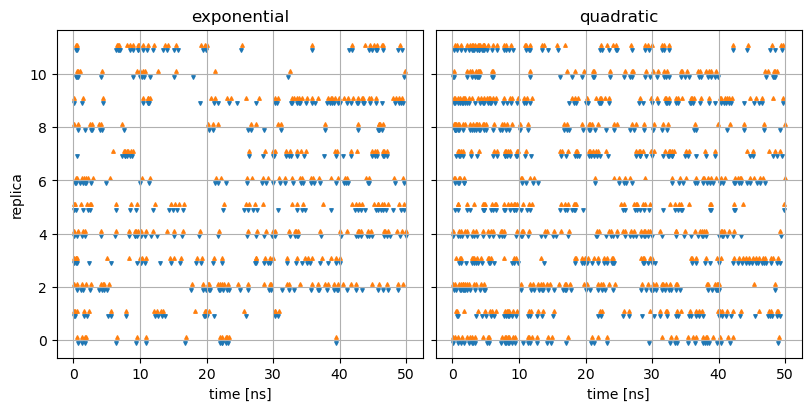

In [22]:
def roundtrip_plot(sim, ax=None, title=None):
    TIME_PER_FRAME = 50 / 250_000
    ax = ax or plt.gca()
    down_events = []
    down_events_state = []
    up_events = []
    up_events_state = []
    for i, col in enumerate(get_roundtrip_events(sim).T):
        n_down = (col == -1).sum()
        down_events.append(np.flatnonzero(col == -1) * TIME_PER_FRAME)
        down_events_state.append(np.array([i-0.1]*n_down))
        n_up = (col == 1).sum()
        up_events.append(np.flatnonzero(col == 1) * TIME_PER_FRAME)
        up_events_state.append(np.array([i+0.1]*n_up))
    ax.scatter(np.concatenate(down_events), np.concatenate(down_events_state), marker='v', s=6)
    ax.scatter(np.concatenate(up_events), np.concatenate(up_events_state), marker='^', s=6)
    if title is not None:
        ax.set_title(title)

sim = Simulation("poongavanam-g16", "openff", "hremd-exponential", "chcl3")

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True, layout='constrained')
sim_1 = sim.with_method("hremd-exponential")
sim_2 = sim.with_method("hremd-quadratic")
roundtrip_plot(sim_1, ax=axes[0], title="exponential")
roundtrip_plot(sim_2, ax=axes[1], title="quadratic")
axes[0].set_ylabel("replica")
for ax in axes:
    ax.set_xlabel("time [ns]")
    ax.grid()
plt.savefig("outputs/si-figure-chcl3-g16-roundtrip-events.png", dpi=300)
plt.show()

# SI Figure 2

/tmp/ipykernel_2793470/4281662051.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(rates, "o", **kwargs)


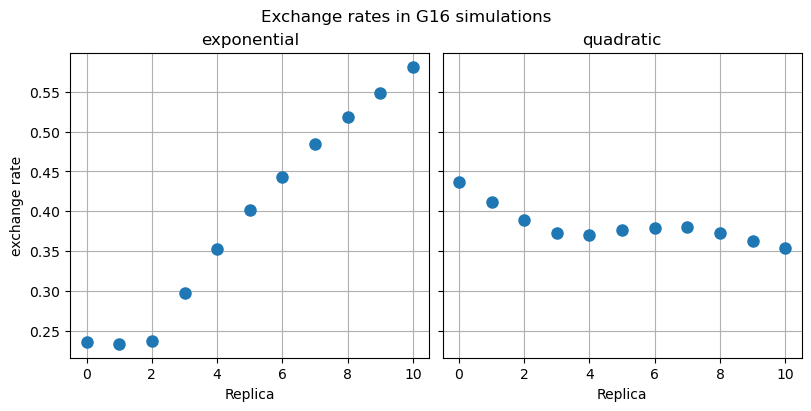

In [23]:
def get_exchange_rates(sim):
    with open(f"outputs/exchange-rates/{sim.compound}_{sim.solvent}_{sim.method}_{sim.forcefield}.json") as f:
        return json.load(f)["success_rates"]

def exchange_rate_plot(sim, ax, **kwargs):
    rates = get_exchange_rates(sim)
    ax.plot(rates, "o", **kwargs)

fig, ax_row = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True, layout='constrained')

simulations = [
    Simulation("poongavanam-g16", "openff", "hremd-exponential", "chcl3"),
]

pad = 5

for sim, symbol in zip(simulations, "ov^"):
    sim_1 = sim.with_method("hremd-exponential")
    sim_2 = sim.with_method("hremd-quadratic")
    exchange_rate_plot(sim_1, ax=ax_row[0], label=COMPOUNDS_PRETTY[sim.compound], marker=symbol, markersize=8)
    exchange_rate_plot(sim_2, ax=ax_row[1], label=COMPOUNDS_PRETTY[sim.compound], marker=symbol, markersize=8)

for ax in ax_row:
    ax.set_xlabel("Replica")
    ax.grid()
ax_row[0].set_title("exponential")
ax_row[1].set_title("quadratic")
ax_row[0].set_ylabel("exchange rate")
fig.suptitle("Exchange rates in G16 simulations")

plt.savefig("outputs/si-figure-chcl3-exchange-rate.png", dpi=300)
plt.show()

# SI Figure 3

/tmp/ipykernel_2793470/2878200755.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(rates, "o", **kwargs)


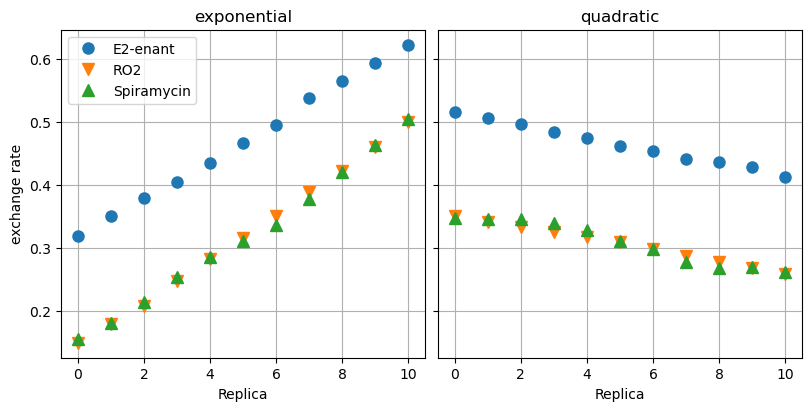

In [24]:
def get_exchange_rates(sim):
    with open(f"outputs/exchange-rates/{sim.compound}_{sim.solvent}_{sim.method}_{sim.forcefield}.json") as f:
        return json.load(f)["success_rates"]

def exchange_rate_plot(sim, ax, **kwargs):
    rates = get_exchange_rates(sim)
    ax.plot(rates, "o", **kwargs)

fig, ax_row = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True, layout='constrained')

simulations = [
    Simulation("poongavanam-e2-enant", "openff", "hremd-exponential", "water"),
    Simulation("roche-2", "openff", "hremd-exponential", "water"),
    Simulation("danelius-spiramycin", "openff", "hremd-exponential", "water"),
]

pad = 5

for sim, symbol in zip(simulations, "ov^"):
    sim_1 = sim.with_method("hremd-exponential")
    sim_2 = sim.with_method("hremd-quadratic")
    exchange_rate_plot(sim_1, ax=ax_row[0], label=COMPOUNDS_PRETTY[sim.compound], marker=symbol, markersize=8)
    exchange_rate_plot(sim_2, ax=ax_row[1], label=COMPOUNDS_PRETTY[sim.compound], marker=symbol, markersize=8)

for ax in ax_row:
    ax.set_xlabel("Replica")
    ax.grid()
ax_row[0].set_title("exponential")
ax_row[1].set_title("quadratic")
ax_row[0].set_ylabel("exchange rate")
ax_row[0].legend()

plt.savefig("outputs/si-figure-water-exchange-rate.png", dpi=300)
plt.show()

# SI Figure 4

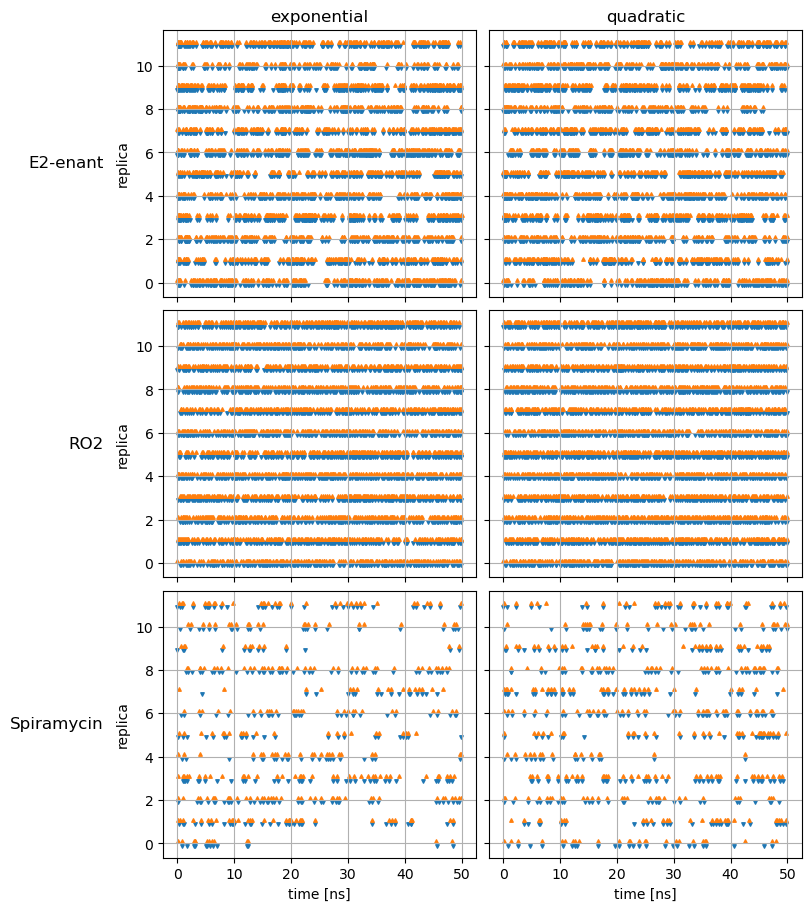

In [25]:
fig, axes = plt.subplots(3, 2, figsize=(8, 9), sharex=True, sharey=True, layout='constrained')

simulations = [
    Simulation("poongavanam-e2-enant", "openff", "hremd-exponential", "water"),
    Simulation("roche-2", "openff", "hremd-exponential", "water"),
    Simulation("danelius-spiramycin", "openff", "hremd-exponential", "water"),
]

pad = 5

for i_row, (sim, ax_row) in enumerate(zip(simulations, axes)):
    sim_1 = sim.with_method("hremd-exponential")
    sim_2 = sim.with_method("hremd-quadratic")
    roundtrip_plot(sim_1, ax=ax_row[0])
    roundtrip_plot(sim_2, ax=ax_row[1])
    if i_row == 0:
        ax_row[0].set_title("exponential")
        ax_row[1].set_title("quadratic")
    ax_row[0].set_ylabel("replica")
    ax_row[0].annotate(
        COMPOUNDS_PRETTY[sim.compound],
        xy=(0, 0.5),
        xytext=(-ax.yaxis.labelpad - pad, 0),
        xycoords=ax_row[0].yaxis.label,
        textcoords='offset points',
        ha='right',
        va='center',
        size='large',
    )
    for ax in ax_row:
        if i_row == len(simulations) - 1:
            ax.set_xlabel("time [ns]")
        ax.grid()

plt.savefig("outputs/si-figure-water-roundtrips.png", dpi=300)
plt.show()

# SI Figure 5

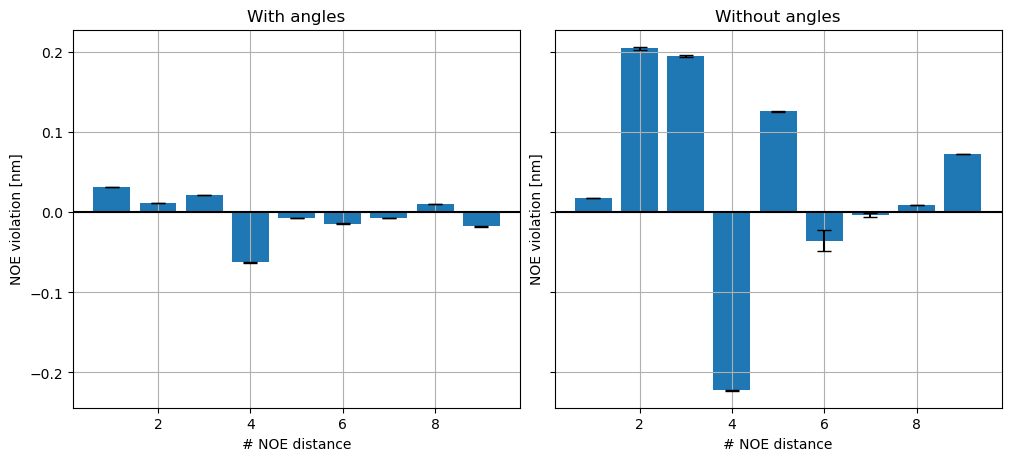

In [26]:
ANGSTROM_PER_NM = 10.

def violation_plot(simulation, ax=None):
    ax = ax or plt.gca()
    plot_df = get_results_table(simulation)
    # Plot
    ax.bar(plot_df.index, plot_df["violation"] / ANGSTROM_PER_NM, label='full')
    N_CHUNKS = 5
    std = np.array([
        (plot_df[f'distance_split_{i}'] - plot_df['distance_ab']).values
        for i in range(N_CHUNKS)
    ]).std(0)
    ax.errorbar(plot_df.index, plot_df["violation"] / ANGSTROM_PER_NM, std / ANGSTROM_PER_NM, fmt='k.', markersize=0, capsize=5)
    ax.axhline(0, color='k')
    ax.set(xlabel='# NOE distance', ylabel='NOE violation [nm]')
    tick_spacing = max(2, int(np.ceil(len(plot_df) / 12)))
    ax.xaxis.set_major_locator(plt.MultipleLocator(tick_spacing))

fig, axes = plt.subplots(1, 2, figsize=(10, 4.5), sharey=True, layout='constrained')
sims = {
    "With angles": Simulation("peng-lorlatinib", "openff", "hremd-with-angles", "chcl3"),
    "Without angles": Simulation("peng-lorlatinib", "openff", "hremd-quadratic", "chcl3"),
}

for ax, (title, sim) in zip(axes, sims.items()):
    violation_plot(sim, ax=ax)
    ax.set_title(title)
    ax.grid()
plt.savefig("outputs/si-figure-lorlatinib-with-without-angles.png", dpi=300)
plt.show()

# SI Figures with all bar plots
## SI Figure 6: Chloroform

File loading error in Simulation('danelius-rifampicin', 'opls', 'hremd-quadratic', 'chcl3', 0)


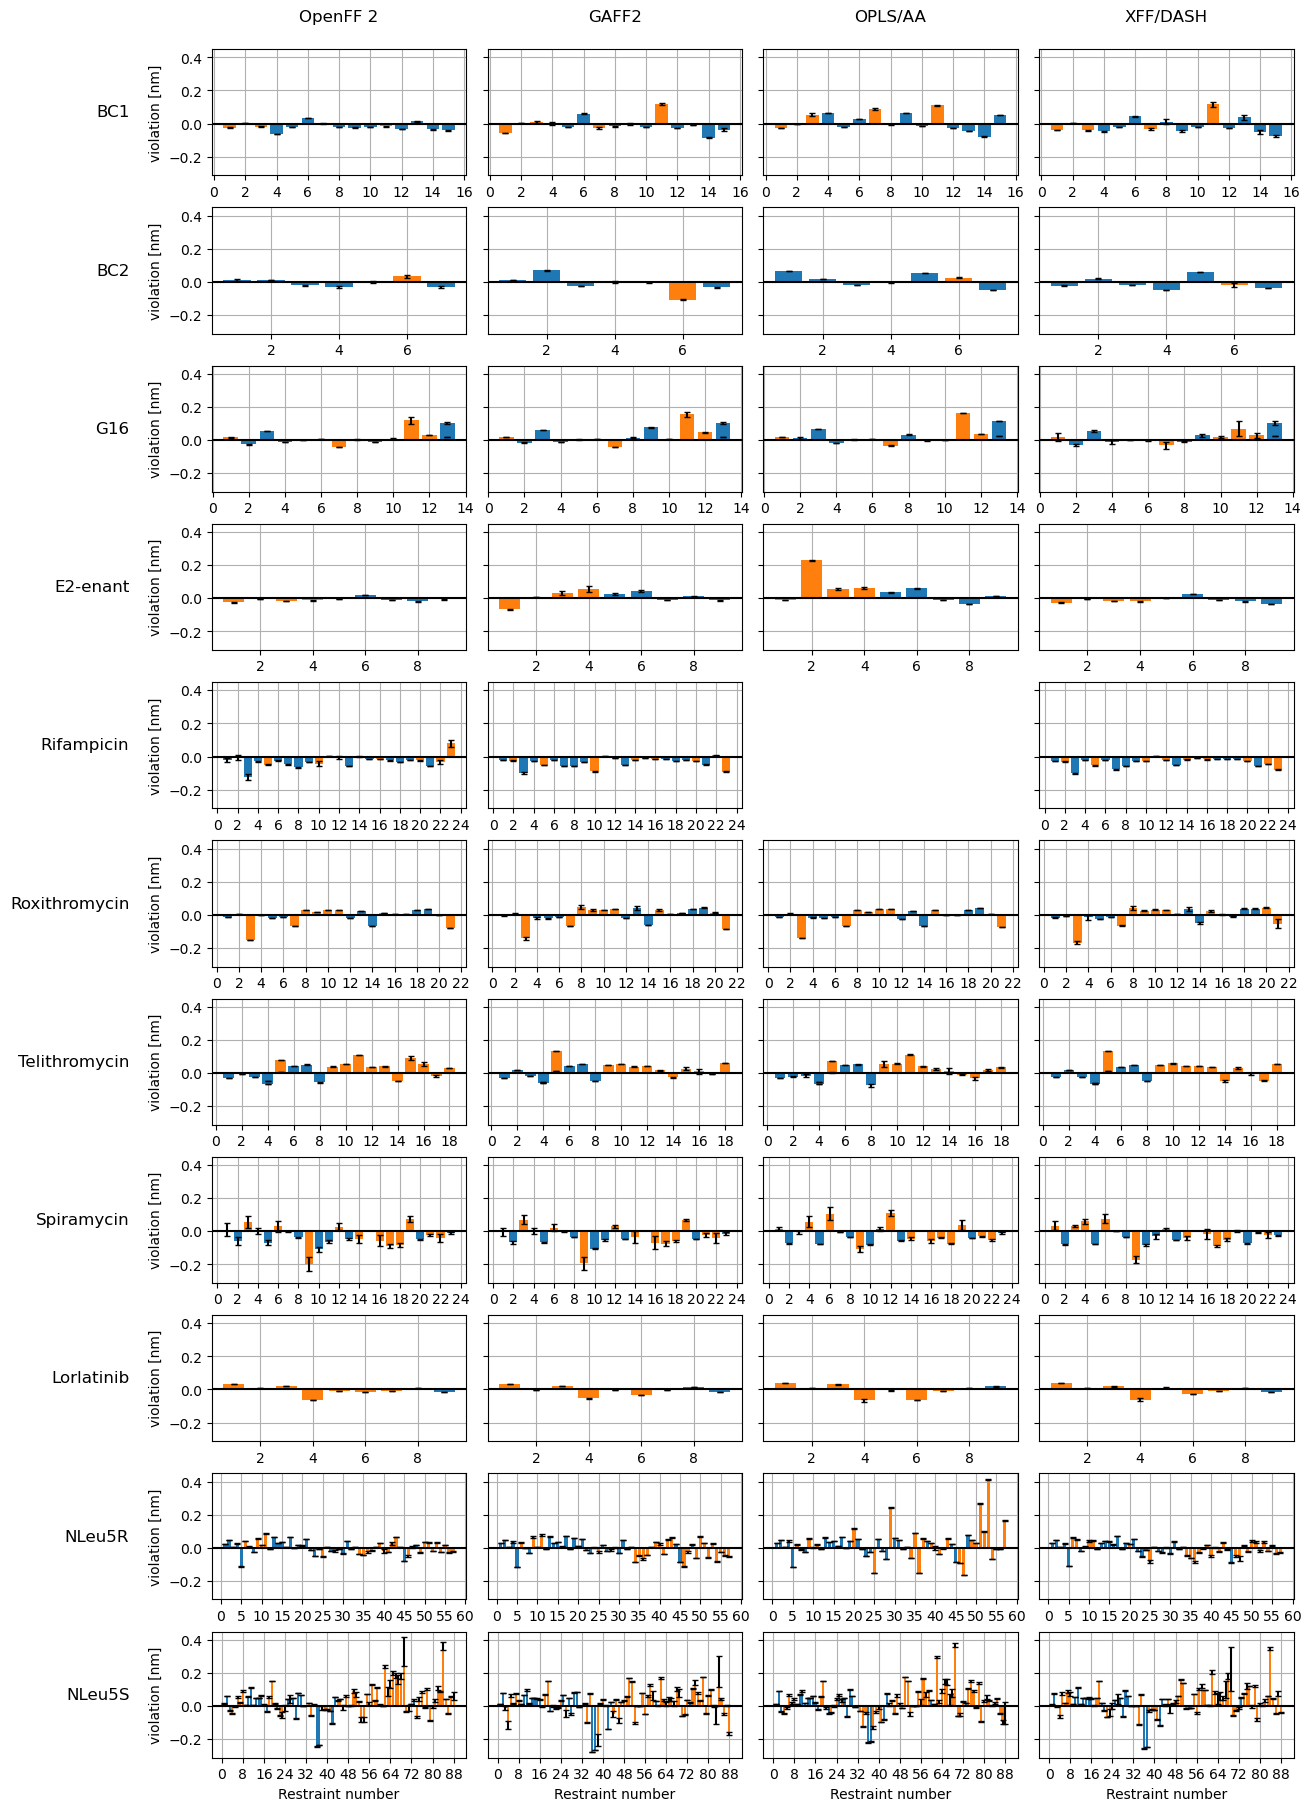

In [18]:
ANGSTROM_PER_NM = 10.

def make_plot(simulation, frame_selection=None, ax=None, use_ring_distance=False, restraints_df=None):
    ax = ax or plt.gca()
    plot_df = get_results_table(simulation)
    # Plot
    ax.bar(plot_df.query('top_distance <= 4.0').index, plot_df.query('top_distance <= 4.0')['violation'] / ANGSTROM_PER_NM, label='≤ 4 bonds')
    ax.bar(plot_df.query('top_distance > 4.0').index, plot_df.query('top_distance > 4.0')['violation'] / ANGSTROM_PER_NM, label='> 4 bonds')
    N_CHUNKS = 5
    std = np.array([
        (plot_df[f'distance_split_{i}'] - plot_df['distance_ab']).values
        for i in range(N_CHUNKS)
    ]).std(0)
    ax.errorbar(plot_df.index, plot_df['violation'] / ANGSTROM_PER_NM, std / ANGSTROM_PER_NM, fmt='k.', markersize=0, capsize=2)
    #ax.legend()
    ax.axhline(0, color='k')
    # limit the number of x-ticks. Note: there will often be one more, since matplotlib extends the plot a bit.
    max_number_of_ticks = 12
    tick_spacing = max(2, int(np.ceil(len(plot_df) / max_number_of_ticks)))
    ax.xaxis.set_major_locator(plt.MultipleLocator(tick_spacing))

fig, axes = plt.subplots(11, 4, figsize=(13, 18), sharey=True, layout='constrained')
CHCL3_COMPOUNDS_PRETTY = {k: v for k, v in COMPOUNDS_PRETTY.items() if not "charged" in k and not k.startswith("roche")}

for axline, (cmp, compound_pretty) in zip(axes, CHCL3_COMPOUNDS_PRETTY.items()):
    for ax, (ff, ff_pretty) in zip(axline, FORCEFIELDS_PRETTY.items()):
        sim = Simulation(cmp, ff, standard_md_method(cmp), "chcl3")
        try:
            make_plot(sim, ax=ax)
        except FileNotFoundError:
            ax.set_visible(False)
            print("File loading error in", sim)
            continue
        if axline[0] is axes[0, 0]:  # first row
            ax.set_title(ff_pretty, pad=20)
        ax.grid()
        ax.set_axisbelow(True)
    _pad = 10
    axline[0].annotate(
        compound_pretty, xy=(0., 0.5), xytext=(-axline[0].yaxis.labelpad - _pad, 0),
        xycoords=axline[0].yaxis.label, textcoords='offset points',
        size='large', ha='right', va='center',
    )
    axline[0].set_ylabel("violation [nm]")

for ax in axes[-1]: # last row
    ax.set_xlabel("Restraint number")
# for SI figures I think it's ok to use SVG.
plt.savefig("outputs/si-figure-6-all-bar-plots-chloroform.svg")
plt.show()

## SI Figure 7: Water

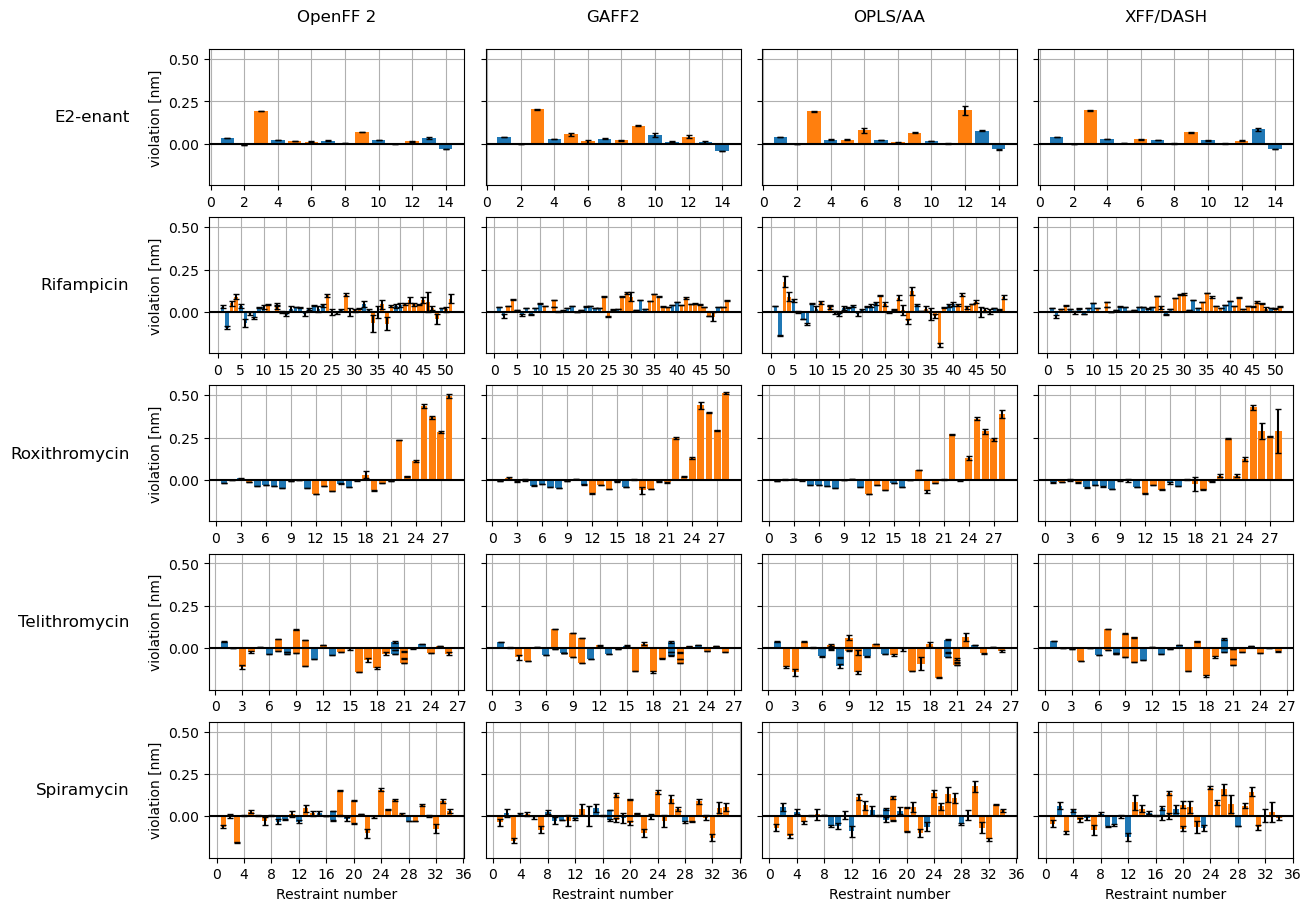

In [19]:
WAT_COMPOUNDS_PRETTY = {k: v for k, v in COMPOUNDS_PRETTY.items() if k in ("danelius-roxithromycin-charged", "danelius-telithromycin-charged", "danelius-rifampicin-charged", "danelius-spiramycin-charged", "poongavanam-e2-enant")}
fig, axes = plt.subplots(len(WAT_COMPOUNDS_PRETTY), 4, figsize=(13, 9), sharey=True, layout='constrained')

for axline, (cmp, compound_pretty) in zip(axes, WAT_COMPOUNDS_PRETTY.items()):
    for ax, (ff, ff_pretty) in zip(axline, FORCEFIELDS_PRETTY.items()):
        sim = Simulation(cmp, ff, standard_md_method(cmp), "water")
        make_plot(sim, ax=ax)
        if axline[0] is axes[0, 0]:  # first row
            ax.set_title(ff_pretty, pad=20)
        ax.grid()
        ax.set_axisbelow(True)
    _pad = 10
    axline[0].annotate(
        compound_pretty, xy=(0., 0.5), xytext=(-axline[0].yaxis.labelpad - _pad, 0),
        xycoords=axline[0].yaxis.label, textcoords='offset points',
        size='large', ha='right', va='center',
    )
    axline[0].set_ylabel("violation [nm]")

for ax in axes[-1]: # last row
    ax.set_xlabel("Restraint number")
# for SI figures I think it's ok to use SVG.
plt.savefig("outputs/si-figure-7-all-bar-plots-water.svg")
plt.show()

## SI Figure 8: DMSO

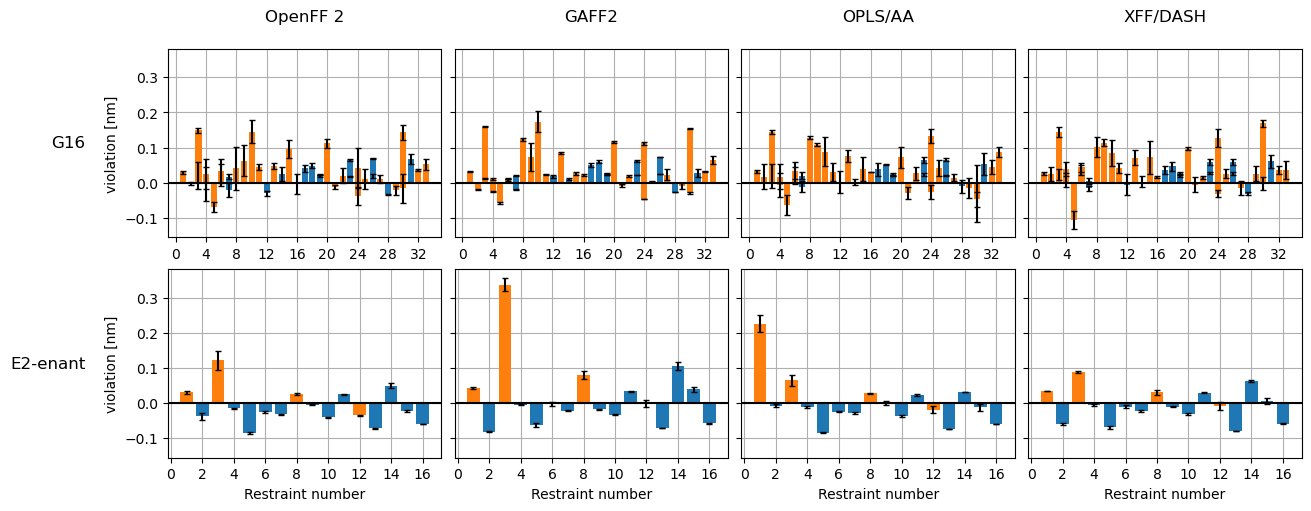

In [20]:
DMSO_COMPOUNDS_PRETTY = {k: v for k, v in COMPOUNDS_PRETTY.items() if k in ("poongavanam-e2-enant", "poongavanam-g16")}
fig, axes = plt.subplots(len(DMSO_COMPOUNDS_PRETTY), 4, figsize=(13, 5), sharey=True, layout='constrained')

for axline, (cmp, compound_pretty) in zip(axes, DMSO_COMPOUNDS_PRETTY.items()):
    for ax, (ff, ff_pretty) in zip(axline, FORCEFIELDS_PRETTY.items()):
        sim = Simulation(cmp, ff, standard_md_method(cmp), "dmso")
        make_plot(sim, ax=ax)
        if axline[0] is axes[0, 0]:  # first row
            ax.set_title(ff_pretty, pad=20)
        ax.grid()
        ax.set_axisbelow(True)
    _pad = 10
    axline[0].annotate(
        compound_pretty, xy=(0., 0.5), xytext=(-axline[0].yaxis.labelpad - _pad, 0),
        xycoords=axline[0].yaxis.label, textcoords='offset points',
        size='large', ha='right', va='center',
    )
    axline[0].set_ylabel("violation [nm]")

for ax in axes[-1]: # last row
    ax.set_xlabel("Restraint number")
# for SI figures I think it's ok to use SVG.
plt.savefig("outputs/si-figure-8-all-bar-plots-dmso.svg")
plt.show()

# Table 3: Standard deviations

In [27]:
PUBLIC_COMPOUNDS = {
    "chcl3": [
        "begnini-compound-1", "begnini-compound-2", "poongavanam-g16", "poongavanam-e2-enant", "danelius-rifampicin",
        "danelius-roxithromycin", "danelius-telithromycin", "danelius-spiramycin", "peng-lorlatinib", "comeau-nleu5r", "comeau-nleu5s"
    ],
    "water": ["poongavanam-e2-enant", "danelius-rifampicin-charged", "danelius-roxithromycin-charged", "danelius-telithromycin-charged", "danelius-spiramycin-charged"],
    "dmso": ["poongavanam-g16", "poongavanam-e2-enant"],
}

In [28]:
split_cols = [f'distance_split_{i}' for i in range(5)]
def get_std_per_distance(solvent):
    out = pd.Series()
    for compound in PUBLIC_COMPOUNDS[solvent]:
        sim = Simulation(compound, 'openff', standard_md_method(compound), solvent)
        split_std = get_results_table(sim)[split_cols].std(1)
        out[COMPOUNDS_PRETTY[compound]] = root_mean_square(split_std)
    return out
print(
    pd.DataFrame({
        "Chloroform": get_std_per_distance("chcl3"),
        "Water": get_std_per_distance("water"),
        "DMSO": get_std_per_distance("dmso"),
    }).divide(10).rename_axis("Compound")#  .to_latex(na_rep=" "*5, float_format="%.4f")
)

               Chloroform     Water      DMSO
Compound                                     
BC1              0.002387       NaN       NaN
BC2              0.006064       NaN       NaN
E2-enant         0.002649  0.002571  0.008658
G16              0.006563       NaN  0.027601
Lorlatinib       0.000413       NaN       NaN
NLeu5R           0.003307       NaN       NaN
NLeu5S           0.014888       NaN       NaN
Rifampicin       0.009651  0.020021       NaN
Roxithromycin    0.000332  0.006339       NaN
Spiramycin       0.024678  0.012396       NaN
Telithromycin    0.004649  0.004823       NaN


# Table with SMILES for SI

In [29]:
smiles_df = pd.Series({
    c: Chem.MolToSmiles(mol)
    for c, mol in mols.items()
}).rename('SMILES').rename_axis("compound").to_frame().join(pd.Series(COMPOUNDS_PRETTY, name="Compound"))

In [30]:
# for export to markdown format:
# print(smiles_df["SMILES"].map(lambda x: "`" + x + "`").to_markdown())
smiles_df["SMILES"]

compound
begnini-compound-1                COC(=O)[C@H]1CSCc2ccccc2C(=O)OC[C@@H](NC(=O)[C...
begnini-compound-2                COC(=O)[C@@H]1CSCc2ccccc2C(=O)OC[C@@H](NC(=O)[...
poongavanam-g16                   Cc1ccc(S(=O)(=O)N(C)C[C@@H]2OCCCC[C@@H](C)Oc3c...
poongavanam-e2-enant              CO[C@H]1CN(C)C(=O)c2cccc(C#N)c2OC[C@H]2O[C@@H]...
danelius-rifampicin               CO[C@H]1/C=C/O[C@@]2(C)Oc3c(C)c(O)c4c(O)c(c(/C...
danelius-roxithromycin            CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...
danelius-telithromycin            CC[C@H]1OC(=O)[C@H](C)C(=O)[C@H](C)[C@@H](O[C@...
danelius-spiramycin               CO[C@@H]1[C@@H](O[C@@H]2O[C@H](C)[C@@H](O[C@H]...
danelius-rifampicin-charged       CO[C@H]1/C=C/O[C@@]2(C)Oc3c(C)c(O)c4c(O)c(c(/C...
danelius-roxithromycin-charged    CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...
danelius-telithromycin-charged    CC[C@H]1OC(=O)[C@H](C)C(=O)[C@H](C)[C@@H](O[C@...
danelius-spiramycin-charged       CO[C@@H]1[C@@H](O[C@@H]2O[C@H](C)

# Render lorlatinib

In [ ]:
lor_md_wo_angles = md.load("/localhome/fwaibl/macrocycle-ff-benchmark/peng-lorlatinib/chcl3/hremd-new-states/openff/outputs/remd0/confout.gro")

In [ ]:
lor_md = md.load("outputs/clustering/peng-lorlatinib-cluster.c0.pdb")
lor_ref = md.load("/localhome/fwaibl/macrocycle-ff-benchmark/peng-lorlatinib/conformer-comparison/lorlatinib-ref-conformer-water.pdb")
#lor_ref.top = lor_md.top
#lor_md.superpose(lor_ref, 0)

In [ ]:
view = nv.show_mdtraj(lor_ref)
#view.add_trajectory(lor_md)
view

In [ ]:
traj_mol0 = lor_md_wo_angles.atom_slice(lor_md_wo_angles.top.select("resid 0"))
traj_mol0.center_coordinates()
view = nv.show_mdtraj(traj_mol0)
view